Zero-shot MAE: 12.68
Zero-shot SMAPE: 2.71%


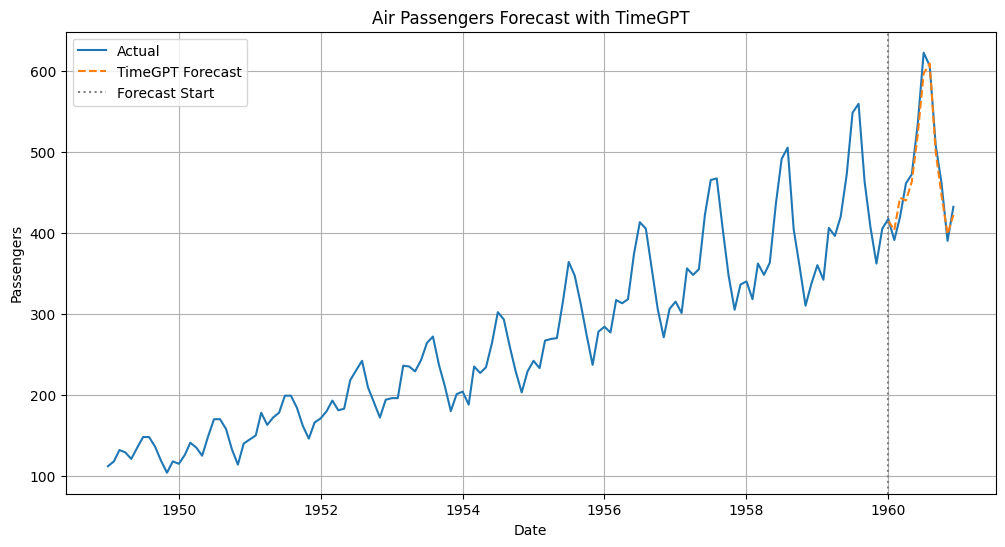

In [8]:
!pip install nixtla

import pandas as pd
from nixtla import NixtlaClient
import matplotlib.pyplot as plt

# Initialize client with your API key
from google.colab import userdata
nixtla_client = NixtlaClient(api_key=userdata.get('timegpt'))

# Load Air Passengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.columns = ["Date", "Passengers"]
df["Date"] = pd.to_datetime(df["Date"])
df["Airline"] = "TWA"  # fake ID for grouping

# Prepare train/test
test_df = df.groupby("Airline").tail(12)
train_df = df.drop(test_df.index).reset_index(drop=True)

# Forecast with TimeGPT (zero-shot)
preds_df = nixtla_client.forecast(
    df=train_df,
    h=12,
    time_col="Date",
    id_col="Airline",
    target_col="Passengers"
)

# Merge predictions with actuals for evaluation
eval_df = pd.merge(test_df, preds_df, on=["Airline", "Date"], how="left")

# Evaluation metrics
def mean_absolute_error(y_true, y_pred):
    return (y_true - y_pred).abs().mean()

def symmetric_mape(y_true, y_pred):
    return (2 * (y_true - y_pred).abs() / (y_true.abs() + y_pred.abs())).replace([float("inf")], pd.NA).dropna().mean() * 100

mae = mean_absolute_error(eval_df["Passengers"], eval_df["TimeGPT"])
smape = symmetric_mape(eval_df["Passengers"], eval_df["TimeGPT"])

print(f"Zero-shot MAE: {mae:.2f}")
print(f"Zero-shot SMAPE: {smape:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Passengers"], label="Actual")
plt.plot(eval_df["Date"], eval_df["TimeGPT"], label="TimeGPT Forecast", linestyle="--")
plt.axvline(test_df["Date"].min(), color="gray", linestyle=":", label="Forecast Start")
plt.legend()
plt.title("Air Passengers Forecast with TimeGPT")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()
